 # Import Required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import string
import re


sns.set()

# Load the Dataset

In [4]:
df = pd.read_csv('reviews_output.csv')
df

,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
...,...,...,...,...,...,...,...,...,...
194434,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014"
194435,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014"
194436,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014"
194437,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014"


# EDA

In [6]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'Rating',
       'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [7]:
df.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
Rating             int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

In [8]:
df.shape

(194439, 9)

In [9]:
df.isnull().any()

reviewerID        False
asin              False
reviewerName       True
helpful           False
reviewText         True
Rating            False
summary            True
unixReviewTime    False
reviewTime        False
dtype: bool

In [10]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3525
helpful              0
reviewText          99
Rating               0
summary              1
unixReviewTime       0
reviewTime           0
dtype: int64

In [11]:
df_no_mv=df.dropna(subset=['reviewerName', 'reviewText', 'summary'], axis=0)

In [12]:
df_no_mv.isnull().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
Rating            0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [13]:
df_no_mv.drop('unixReviewTime',axis=1,inplace=True)

C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1328\637934400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_mv.drop('unixReviewTime',axis=1,inplace=True)


In [14]:
df_no_mv.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'Rating',
       'summary', 'reviewTime'],
      dtype='object')

In [15]:
df_no_mv.duplicated().sum()

0

In [16]:
df_no_mv['Rating'].value_counts()

Rating
5    106508
4     39285
3     21070
1     13067
2     10884
Name: count, dtype: int64

# Remove Conflicting Reviews (Same text, different ratings)

In [18]:
# Step 1: Check how many reviews have conflicting ratings
conflict_counts = (
    df_no_mv.groupby('reviewText')['Rating']
      .nunique()
      .reset_index()
      .rename(columns={'Rating': 'unique_ratings'})
)
conflict_counts

,reviewText,unique_ratings
0,While the texture and feel of this keyboard ...,1
1,TheOXA 2600mAh Mini Power Bankis an ultra-sli...,1
2,thing this is the coolest case that is out th...,1
3,! ! !! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !...,1
4,! fits good kind of slippery though. love the ...,1
...,...,...
190662,zerolemon is the truth there's just nothing el...,1
190663,zps for I phone 5 5g 5s dream catcher Aztec wo...,1
190664,~ For just making mobile calls anywhere in the...,1
190665,~First I'd like to start off with I haven't ac...,1


In [19]:
# Step 2: Get texts that have more than 1 unique rating
conflicting_reviews = conflict_counts[conflict_counts['unique_ratings'] > 1]['reviewText']

In [20]:
# Filter original df for only conflicting reviews
conflict_df = df[df['reviewText'].isin(conflicting_reviews)]

# Group by reviewText to see all associated ratings
conflict_summary = conflict_df.groupby('reviewText')['Rating'].unique().reset_index()

# Optional: Show a few rows
conflict_summary.head(10)


,reviewText,Rating
0,#NAME?,"[4, 5, 3, 2]"
1,GOOD,"[5, 3]"
2,Good,"[4, 5]"
3,Good case,"[4, 5]"
4,Good product,"[4, 5]"
5,I bought the case for the wrong note. But I ha...,"[4, 3]"
6,I like it,"[4, 5]"
7,I love it,"[4, 5]"
8,Like it,"[4, 5]"
9,Love it,"[1, 5, 4]"


In [21]:
# Step 3: Remove those reviews from the main DataFrame
df_cleaned = df_no_mv[~df_no_mv['reviewText'].isin(conflicting_reviews)]

In [22]:
# Result: no same review text with different ratings
print(f"Original dataset size: {len(df_no_mv)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")

Original dataset size: 190814
Cleaned dataset size: 190708


In [23]:
# Confirm no conflicts remain
check = df_cleaned.groupby('reviewText')['Rating'].nunique()
print("Max unique ratings per reviewText:", check.max())  # Should be 1


Max unique ratings per reviewText: 1


In [24]:
df_cleaned['Rating'].value_counts()

Rating
5    106451
4     39249
3     21060
1     13066
2     10882
Name: count, dtype: int64

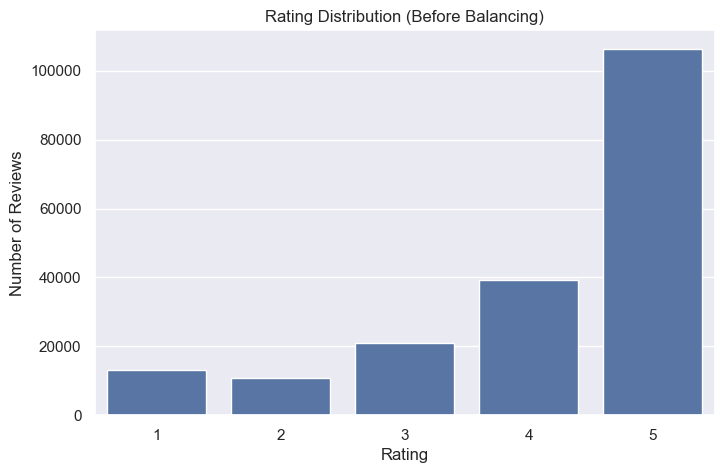

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df_cleaned)
plt.title("Rating Distribution (Before Balancing)")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

#  Clean Review Text (Punctuation, Spaces, Stopwords)

In [27]:
# 1. Pre-split cleaning: punctuation, emojis, spaces
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r'[' + string.punctuation + ']', '', text)           # remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)                           # remove emojis / non-ASCII
    text = re.sub(r'\s+', ' ', text).strip()                            # remove extra spaces, tabs, etc.
    return text

df_cleaned['reviewText'] = df_cleaned['reviewText'].apply(basic_clean)

C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1328\1305039340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['reviewText'] = df_cleaned['reviewText'].apply(basic_clean)


# Filter by Review Length 

C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1328\3298028223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['review_length'] = df_cleaned['reviewText'].str.split().str.len()


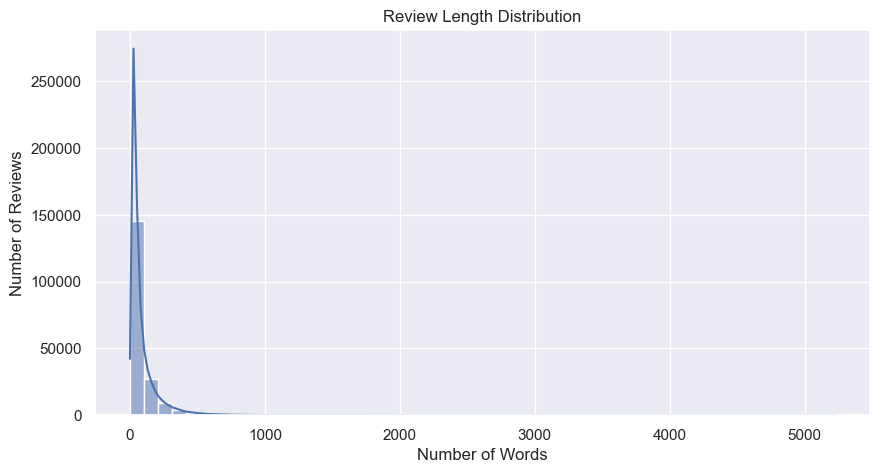

In [29]:
df_cleaned['review_length'] = df_cleaned['reviewText'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='review_length', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()


In [30]:
df_filtered = df_cleaned[
    (df_cleaned['review_length'] > 10) & 
    (df_cleaned['review_length'] <= 1000)
]

In [31]:
print("Before filtering:", len(df_cleaned))
print("After filtering:", len(df_filtered))


Before filtering: 190708
After filtering: 188380


C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1328\49822069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['review_length'] = df_filtered['reviewText'].str.split().str.len()


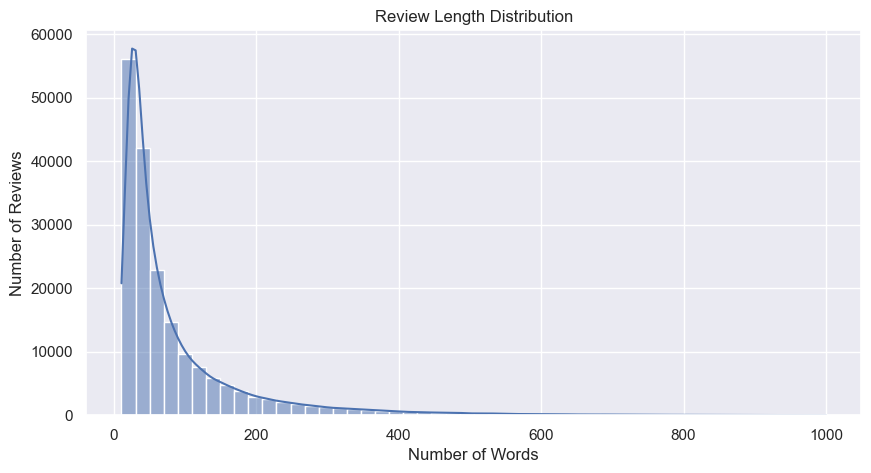

In [32]:
df_cleaned['review_length'] = df_filtered['reviewText'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='review_length', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()


In [33]:
df_filtered['Rating'].value_counts()

Rating
5    105006
4     38830
3     20842
1     12913
2     10789
Name: count, dtype: int64

In [34]:
df_balanced = (df_filtered.groupby('Rating', group_keys=False)
               .apply(lambda x: x.sample(2000, random_state=42))
               .sample(frac=1, random_state=42)
               .reset_index(drop=True)
)

# Check balanced result
print(df_balanced['Rating'].value_counts())

Rating
4    2000
3    2000
1    2000
2    2000
5    2000
Name: count, dtype: int64


C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1328\3935043619.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(2000, random_state=42))


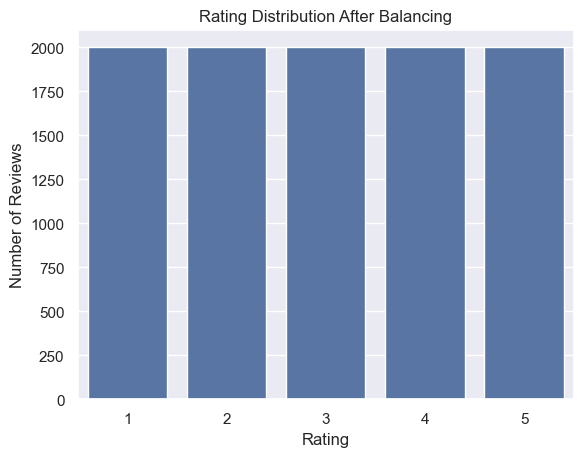

In [35]:
sns.countplot(x='Rating', data=df_balanced)
plt.title("Rating Distribution After Balancing")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [36]:
rating_counts = df_balanced['Rating'].value_counts().sort_index()

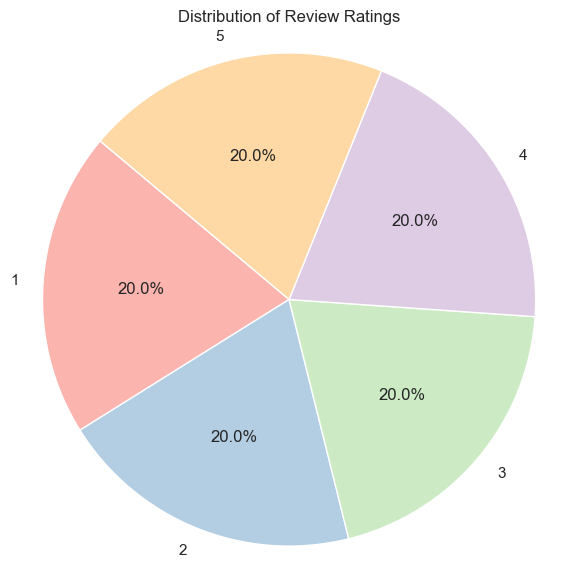

In [37]:
# Labels and sizes
labels = rating_counts.index.astype(str)
sizes = rating_counts.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

In [38]:
df_balanced.to_csv('balanced_reviews_dataset1.csv', index=False)

In [39]:
used_balanced = df_balanced.index
df_remaining = df_filtered.drop(index=used_balanced, errors='ignore')

In [40]:
print("Total cleaned dataset:", len(df_filtered))
print("Balanced dataset:", len(df_balanced))
print("Remaining dataset after exclusion:", len(df_filtered.drop(index=df_balanced.index, errors='ignore')))


Total cleaned dataset: 188380
Balanced dataset: 10000
Remaining dataset after exclusion: 178554


In [41]:
# Get the remaining data
df_remaining = df_filtered.drop(index=df_balanced.index, errors='ignore')

In [42]:
df_remaining['Rating'].value_counts()

Rating
5    99945
4    36811
3    19750
1    11953
2    10095
Name: count, dtype: int64

In [43]:
# Define how many samples to take for each rating
target_counts = {
    1: 1000,
    2: 1500,
    3: 2500,
    4: 3000,
    5: 2000
}


df_imbalanced_scaled = pd.concat([
    df_remaining[df_remaining['Rating'] == rating].sample(n=count, random_state=42)
    for rating, count in target_counts.items()
]).sample(frac=1, random_state=42).reset_index(drop=True)


print(df_imbalanced_scaled['Rating'].value_counts())



Rating
4    3000
3    2500
5    2000
2    1500
1    1000
Name: count, dtype: int64


In [44]:
df_imbalanced_scaled.shape

(10000, 9)

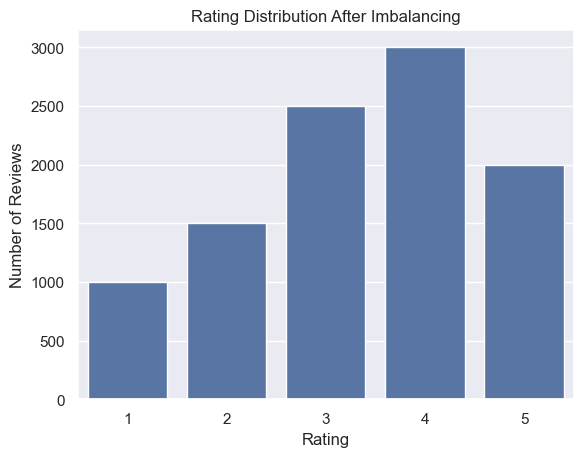

In [45]:
sns.countplot(x='Rating', data=df_imbalanced_scaled)
plt.title("Rating Distribution After Imbalancing")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [46]:
df_imbalanced_scaled.to_csv('imbalanced_reviews_dataset1.csv', index=False)

In [47]:
all_in = df_balanced.isin(df_imbalanced_scaled).all().all()
print("All rows in balanced exist in imbalanced:", all_in)


All rows in balanced exist in imbalanced: False


In [92]:
rating_counts_imbalanced = df_imbalanced_scaled['Rating'].value_counts().sort_index()

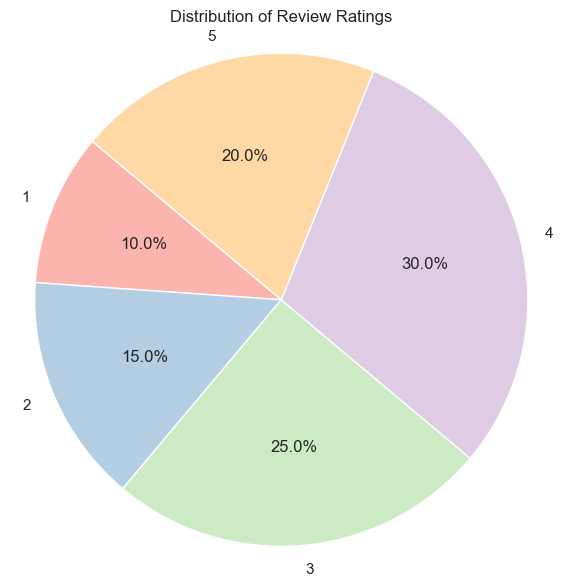

In [94]:
# Labels and sizes
labels = rating_counts_imbalanced.index.astype(str)
sizes = rating_counts_imbalanced.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()